# Importing Libraries

In [1]:
import numpy as np
import os
import tensorflow as tf
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from absl import logging
import shutil

from tflite_model_maker import object_detector
from tflite_model_maker.object_detector import DataLoader
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec

C:\Users\fahad\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\fahad\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter

# Setting Up for TensorFlow 2.0

In [2]:
assert tf.__version__.startswith('2')

# Suppress TensorFlow and absl logs for cleaner output
tf.get_logger().setLevel('ERROR')
logging.set_verbosity(logging.ERROR)

# Dataset Preprocessing and Augmentation

### Directory paths

In [3]:
base_dir = r'Object-detection-dataset'
train_dir = 'Object-detection-dataset/train'
valid_dir = 'Object-detection-dataset/valid'

### Extracting Label Map

In [4]:
# Extract labels from XML files
def extract_labels(directory):
    labels = set()
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            tree = ET.parse(os.path.join(directory, filename))
            root = tree.getroot()
            for obj in root.findall('object'):
                labels.add(obj.find('name').text)
    return labels

# Extract and merge all labels
train_labels = extract_labels(train_dir)
valid_labels = extract_labels(valid_dir)
all_labels = sorted(train_labels.union(valid_labels))

# Convert to the required label_map
label_map = {i + 1: name for i, name in enumerate(all_labels)}

# Display the labels
print("Labels used in your annotations:")
for label in all_labels:
    print(label)

Labels used in your annotations:
Tom Tom
aeroplane
apple
backpack
banana
baseball bat
baseball glove
bear
bed
bench
bicycle
bin
bird
boat
book
bottle
bowl
broccoli
bus
cake
car
cat
cell phone
chair
clock
cng
cow
cup
diningtable
dog
donut
door
elephant
fire hydrant
fork
frisbee
giraffe
glass partition
handbag
horse
hot dog
keyboard
kite
knife
laptop
microwave
motorbike
motorcycle
mouse
orange
oven
parking meter
person
pillar
pizza
pottedplant
railing
refrigerator
remote
rickshaw
sandwich
scissors
sheep
shelf
sink
skateboard
skis
snowboard
sofa
spoon
sports ball
stair
stop sign
suitcase
surfboard
table
teddy bear
tempu
tennis racket
tie
toilet
traffic light
train
tree
truck
tvmonitor
umbrella
van
vase
wine glass
zebra


### Data Augmentation

In [5]:
def augment_image(image, bbox):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, bbox

### Apply and Save Augmented Images

In [6]:
aug_dir = os.path.join(base_dir, 'train_augmented')
os.makedirs(aug_dir, exist_ok=True)

for file in os.listdir(train_dir):
    if file.endswith('.jpg') or file.endswith('.png'):
        base_name = os.path.splitext(file)[0]
        img_path = os.path.join(train_dir, file)
        xml_path = os.path.join(train_dir, base_name + '.xml')

        if not os.path.exists(xml_path):
            continue  # Skip if annotation missing

        # Load and augment image
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image, channels = 3)
        image = tf.image.resize(image, (384, 384))
        image = tf.cast(image, tf.uint8)

        aug_image, _ = augment_image(image, None)
        aug_image = tf.image.encode_jpeg(tf.cast(aug_image, tf.uint8))

        # Save augmented image
        aug_img_name = base_name + '_aug.jpg'
        aug_img_path = os.path.join(aug_dir, aug_img_name)
        tf.io.write_file(aug_img_path, aug_image)

        # Copy original XML with new name
        aug_xml_name = base_name + '_aug.xml'
        shutil.copy(xml_path, os.path.join(aug_dir, aug_xml_name))

### Merge Original and Augmented Training Data

In [7]:
train_combined_dir = os.path.join(base_dir, 'train_combined')
os.makedirs(train_combined_dir, exist_ok = True)

for src_dir in [train_dir, aug_dir]:
    for f in os.listdir(src_dir):
        shutil.copy(os.path.join(src_dir, f), os.path.join(train_combined_dir, f))

### Load Dataset with Augmented Data

In [8]:
train_data = object_detector.DataLoader.from_pascal_voc(
    train_combined_dir,
    train_combined_dir,
    label_map
)

val_data = object_detector.DataLoader.from_pascal_voc(
    valid_dir,
    valid_dir,
    label_map
)

# Initialize EfficientDet-Lite1 Pretrained Model

In [9]:
spec = model_spec.get("efficientdet_lite1")

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

spec.optimizer = Adam(learning_rate=lr_schedule)

# Model Training

### Training Configuration

In [10]:
IMAGE_SIZE = (384, 384)
BATCH_SIZE = 8
EPOCH_SIZE = 25

### Training

In [11]:
model = object_detector.create(
    train_data,
    model_spec=spec,
    batch_size=BATCH_SIZE,
    train_whole_model=False,  # Freeze backbone, train only detection head
    validation_data=val_data,
    epochs=EPOCH_SIZE,
    do_train=True,
)

Epoch 1/25
102/102 [==============================] - 266s 2s/step - det_loss: 1.9089 - cls_loss: 1.3417 - box_loss: 0.0113 - reg_l2_loss: 0.0204 - loss: 1.9294 - learning_rate: 0.0090 - gradient_norm: 0.6355 - val_det_loss: 1.5682 - val_cls_loss: 1.1858 - val_box_loss: 0.0076 - val_reg_l2_loss: 0.0205 - val_loss: 1.5886
Epoch 2/25
102/102 [==============================] - 259s 3s/step - det_loss: 1.5331 - cls_loss: 1.1376 - box_loss: 0.0079 - reg_l2_loss: 0.0205 - loss: 1.5536 - learning_rate: 0.0099 - gradient_norm: 0.8253 - val_det_loss: 1.4228 - val_cls_loss: 1.0782 - val_box_loss: 0.0069 - val_reg_l2_loss: 0.0205 - val_loss: 1.4433
Epoch 3/25
102/102 [==============================] - 265s 3s/step - det_loss: 1.4120 - cls_loss: 1.0603 - box_loss: 0.0070 - reg_l2_loss: 0.0205 - loss: 1.4325 - learning_rate: 0.0097 - gradient_norm: 0.8494 - val_det_loss: 1.3763 - val_cls_loss: 1.0235 - val_box_loss: 0.0071 - val_reg_l2_loss: 0.0205 - val_loss: 1.3968
Epoch 4/25
102/102 [===========

### Save the Trained Model

In [12]:
model.model.optimizer.learning_rate = tf.constant(0.0001)
model.model.save('efficientdet_lite1_saved_model')

# Model Summary and Plot

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  4234512   
                                                                 
 class_net/class-predict (Se  multiple                 73683     
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 3996      
 bleConv2D)                                                      
                                                                 
Total params: 4,312,191
Trainable params: 4,249,119
Non-trainable params: 63,072
_________________________________________________________________


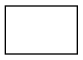

In [13]:
model.model.summary()
plot_model(model.model, show_shapes=True, show_layer_names=True, dpi=96)

# Learning Curve

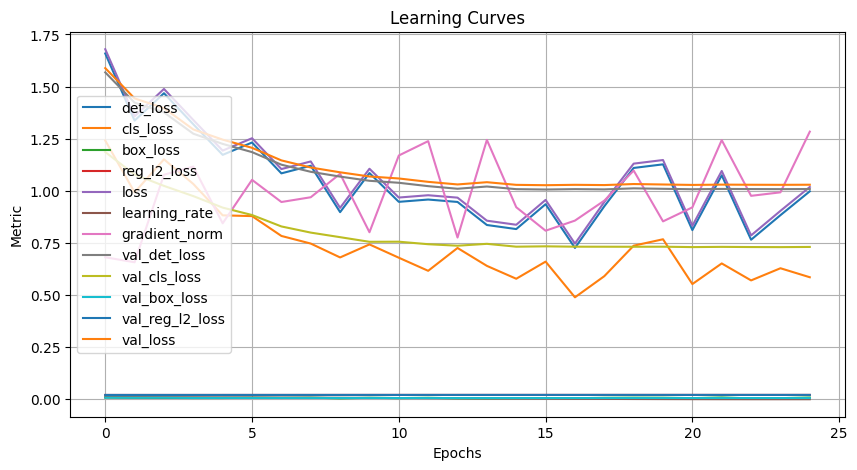

In [14]:
history = model.model.history

if history and hasattr(history, 'history'):
    plt.figure(figsize = (10, 5))
    for key, values in history.history.items():
        plt.plot(values, label=key)
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(True)
    plt.show()

### Model Evaluation

In [15]:
metrics = model.evaluate(val_data)

print("\nEvaluation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

2/2 [==============================] - 182s 60s/step


Evaluation Metrics:
AP: 0.1189
AP50: 0.1935
AP75: 0.1268
APs: 0.0122
APm: 0.1213
APl: 0.2102
ARmax1: 0.1455
ARmax10: 0.2044
ARmax100: 0.2086
ARs: 0.0185
ARm: 0.2008
ARl: 0.3460
AP_/Tom Tom: -1.0000
AP_/aeroplane: 0.1442
AP_/apple: -1.0000
AP_/backpack: 0.0062
AP_/banana: -1.0000
AP_/baseball bat: 0.0000
AP_/baseball glove: 0.0000
AP_/bear: -1.0000
AP_/bed: -1.0000
AP_/bench: 0.1509
AP_/bicycle: 0.0837
AP_/bin: 0.0000
AP_/bird: 0.0081
AP_/boat: 0.0000
AP_/book: 0.0205
AP_/bottle: 0.1767
AP_/bowl: 0.0000
AP_/broccoli: -1.0000
AP_/bus: 0.3696
AP_/cake: 0.0000
AP_/car: 0.2163
AP_/cat: 0.0131
AP_/cell phone: 0.0000
AP_/chair: 0.0903
AP_/clock: 0.0000
AP_/cng: 0.0621
AP_/cow: 0.1941
AP_/cup: 0.1199
AP_/diningtable: 0.1092
AP_/dog: 0.1612
AP_/donut: -1.0000
AP_/door: -1.0000
AP_/elephant: 0.7398
AP_/fire hydrant: 0.0000
AP_/fork: 0.0000
AP_/frisbee: 0.4667
AP_/giraffe: -1.0000
AP_/glass partition: -1.0000
AP_/handbag: 0.0034
AP_/horse: 0.

# Model Quantization [Export TFLite (int8)]

In [18]:
from tflite_model_maker.config import QuantizationConfig, ExportFormat

# Use DataLoader directly
representative_data = train_data

quant_config = QuantizationConfig.for_int8(representative_data)

# Export the quantized model
model.export(
    export_dir='.',
    export_format=[ExportFormat.TFLITE],
    quantization_config=quant_config
)

# Rename the output file
os.rename("model.tflite", "EfficientDet_Lite1_detector_int8.tflite")